In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.augment.spectrogram import CropTime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [5]:
FOLD=1

In [6]:
path = Path("/home/kkalyan/agri-split/data")
df = pd.read_csv(path/"Train_v.csv")

In [7]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [8]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [9]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss(), SGRoll()],
                 get_y=ColReader("label"))

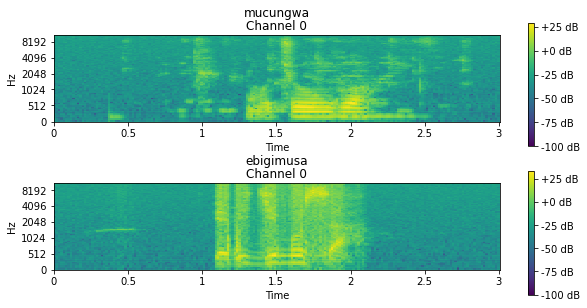

In [10]:
dbunch = auds.dataloaders(df, bs=128)
dbunch.show_batch(figsize=(10, 5))

In [11]:
learn = cnn_learner(dbunch, 
            resnet18, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

In [12]:
x,y = next(iter(learn.dls.train))

In [13]:
x.shape

torch.Size([128, 1, 128, 188])

In [14]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,7.123606,6.660474,0.002703,00:03


epoch,train_loss,valid_loss,accuracy,time
0,7.109698,5.970683,0.010811,00:03
1,7.089298,5.800076,0.016216,00:03
2,7.020804,5.806619,0.005405,00:03


In [15]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,6.861753,5.746230,0.008108,00:03
1,6.856349,5.769304,0.002703,00:03
2,6.783554,5.678964,0.008108,00:03
3,6.754736,5.723743,0.002703,00:03
4,6.738737,5.663813,0.008108,00:03
5,6.679665,5.608185,0.013514,00:03
6,6.627388,5.663108,0.005405,00:04
7,6.546600,5.658149,0.002703,00:03
8,6.454969,5.533393,0.016216,00:04
9,6.357492,5.476554,0.013514,00:04


Better model found at epoch 0 with valid_loss value: 5.746229648590088.
Better model found at epoch 2 with valid_loss value: 5.678963661193848.
Better model found at epoch 4 with valid_loss value: 5.663812637329102.
Better model found at epoch 5 with valid_loss value: 5.608184814453125.
Better model found at epoch 8 with valid_loss value: 5.533393383026123.
Better model found at epoch 9 with valid_loss value: 5.4765543937683105.
Better model found at epoch 10 with valid_loss value: 5.430452346801758.
Better model found at epoch 11 with valid_loss value: 5.3402204513549805.
Better model found at epoch 12 with valid_loss value: 5.298874855041504.
Better model found at epoch 13 with valid_loss value: 5.1346659660339355.
Better model found at epoch 15 with valid_loss value: 4.992616653442383.
Better model found at epoch 16 with valid_loss value: 4.863498210906982.
Better model found at epoch 17 with valid_loss value: 4.714751243591309.
Better model found at epoch 18 with valid_loss value: 

In [16]:
ac_1 = learn.validate(); ac_1

(#2) [3.318005323410034,0.3513513505458832]

In [17]:
# Better model found at epoch 56 with valid_loss value: 4.0540313720703125.

In [18]:
# (#2) [4.127956867218018,0.2243243306875229]